# Physical activity and sleep notebook:

### Contents:

1. Loading dependencies
2. Processing and extraction

## 1. Loading dependencies

In [42]:
#Package loading
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, date, time, timedelta

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib import rc
from matplotlib.dates import date2num
from IPython import display
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.dates as dates
%matplotlib inline

from scipy import stats as sps
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor

import statsmodels.api as sm
from CosinorPy import file_parser, cosinor, cosinor1

import glob
import math
from os import path
from collections import defaultdict
import nolds
import pyActigraphy as pyAc
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 18
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
plt.rc('font', family='serif')

## 2. Processing and extraction

In [2]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
from preprocessing import Subject

filelist = ['dummy5_full.csv','dummy3_full.csv','dummy2_full.csv','dummy1_full.csv']#,
           # 'dummybbvs_1.csv', 'dummybbvs_2.csv']

def get_data(filelist):
    d = defaultdict(dict)
    for idx, filename in enumerate(filelist):
        d[idx] = Subject(filename)
        d[idx].get_METS()
        #d[idx].get_HRV()
        d[idx].get_PA()
        d[idx].get_sleep(q_sleep=0.4, bed_time = '20:00',wake_time = '12:00', seq_length = 15)
        d[idx].get_windows()
        d[idx].get_SRI(q_sleep=0.4)
        #d[idx].get_cosinor()
        d[idx].get_SSA()
        d[idx].get_nonlinear()
        #d[idx].Crespo(zeta=15, zeta_r=50, zeta_a=2,t=.50, alpha='7h', beta='1h',
        #              estimate_zeta=False, seq_length_max=100, verbose=False)
        #Depends on running METS,PA,sleep, windows, SRI, SSA and nonlinear first
        d[idx].get_daily_stats()
    return d

d = get_data(filelist)

In [58]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

#Create populatoin-level stats on daily basis
e = defaultdict(dict)
d_pop = pd.DataFrame()
for idx in d.keys():
    #d[idx].get_daily_stats()
    e[idx] = d[idx].daily_stats.copy()
    e[idx]['sub'] = idx
    e[idx]['RMR'] = d[idx].RMR
    e[idx]['VO2max'] = d[idx].VO2max
    e[idx]['age'] = d[idx].age
    e[idx]['BMI'] = d[idx].BMI
    e[idx]['SRI'] = d[idx].SRI
    d_pop = pd.concat([d_pop,e[idx]],axis=0)
    

new = d_pop.copy()
#Transform to timedelta columns
new['sleep_onset_t'] = new['sleep_onset']-new.index
new['sleep_offset_t'] = new['sleep_offset']-new.index #timedelta64[ns]
new['ENMO_SSA_phi_t'] = new['ENMO_SSA_phi']-new.index
new['mean_hr_SSA_phi_t'] = new['mean_hr_SSA_phi']-new.index

d_pop_t = new.copy()

#print(d_pop_t.head(10))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
#Feature selection and extraction part of the regression pipeline
d_reg = d_pop_t.copy()
#
d_reg2 = d_reg.drop(['sleep_onset', 'sleep_offset','ENMO_SSA_phi','mean_hr_SSA_phi','weekday'],axis=1)

#print(d_reg2.head())
sleep_features = ['TST', 'WASO','AwaNo',
                  'SEff','s_length','dfa_ENMO_sleep','dfa_HR_sleep','dfa_HRV_sleep',
                  'se_ENMO_sleep','se_HR_sleep','se_HRV_sleep','sleep_onset_t','sleep_offset_t']
met_features =['ENMO','MET_Sed','MET_MVPA','MET_VigPA','min_MVPA','min_VigPA','min_LPA']
circ_features = ['ENMO_SSA_per','mean_hr_SSA_per','ENMO_phisleep_delay',
                 'mean_hr_phisleep_delay','ENMO_SSA_phi_t','mean_hr_SSA_phi_t']
deltas = ['TST','ENMO_phisleep_delay','mean_hr_phisleep_delay','sleep_onset_t','sleep_offset_t',
          'ENMO_SSA_phi_t','mean_hr_SSA_phi_t']
shifts = ['ENMO_SSA_per','mean_hr_SSA_per']
fitness = ['RMR','VO2max','BMI','age']
d_reg2[shifts] = d_reg2[shifts].groupby(d_reg2['sub']).shift(-1)
d_reg2[deltas] = d_reg2[deltas].astype('timedelta64[s]')

d_cat = pd.get_dummies(d_reg['weekday'],prefix='weekday',drop_first=True)
#print(d_cat.head())
d_reg2.replace(np.inf, np.nan, inplace=True)
d_reg2 = d_reg2.drop(['sub','ENMO'],axis=1)

scaler = StandardScaler()
d_regs = pd.DataFrame(scaler.fit_transform(d_reg2), columns = d_reg2.columns, index=d_reg2.index).dropna()
d_regsz = pd.concat([d_regs,d_cat],axis=1, join='inner')
#print(d_regs.head())
#print(d_regsz.head())

Index(['MET_VigPA', 'min_VigPA', 'min_LPA', 'dfa_ENMO_wake', 'dfa_HR_wake',
       'se_ENMO_wake', 'mean_hr_SSA_per', 'mean_hr_phisleep_delay',
       'weekday_1.0', 'weekday_5.0'],
      dtype='object')
{'MET_Sed': 3, 'MET_MVPA': 18, 'MET_VigPA': 1, 'min_MVPA': 21, 'min_VigPA': 1, 'min_LPA': 1, 'w_length': 6, 'dfa_ENMO_wake': 1, 'dfa_HR_wake': 1, 'dfa_HRV_wake': 19, 'se_ENMO_wake': 1, 'se_HR_wake': 8, 'se_HRV_wake': 13, 'ENMO_SSA_per': 17, 'mean_hr_SSA_per': 1, 'ENMO_phisleep_delay': 20, 'mean_hr_phisleep_delay': 1, 'RMR': 12, 'VO2max': 10, 'age': 14, 'BMI': 16, 'SRI': 15, 'ENMO_SSA_phi_t': 5, 'mean_hr_SSA_phi_t': 9, 'weekday_1.0': 1, 'weekday_2.0': 7, 'weekday_3.0': 2, 'weekday_4.0': 4, 'weekday_5.0': 1, 'weekday_6.0': 11}
[ 0.25299814 -0.17563705  0.20590596  0.14165556  0.18922178 -0.12093569
  0.13180869  0.14183584 -0.12194405  0.09688961]
train_score: 0.9999996665556823
test_score: -3.4570049162472456
                        0         1
0               MET_VigPA  0.252998
1     

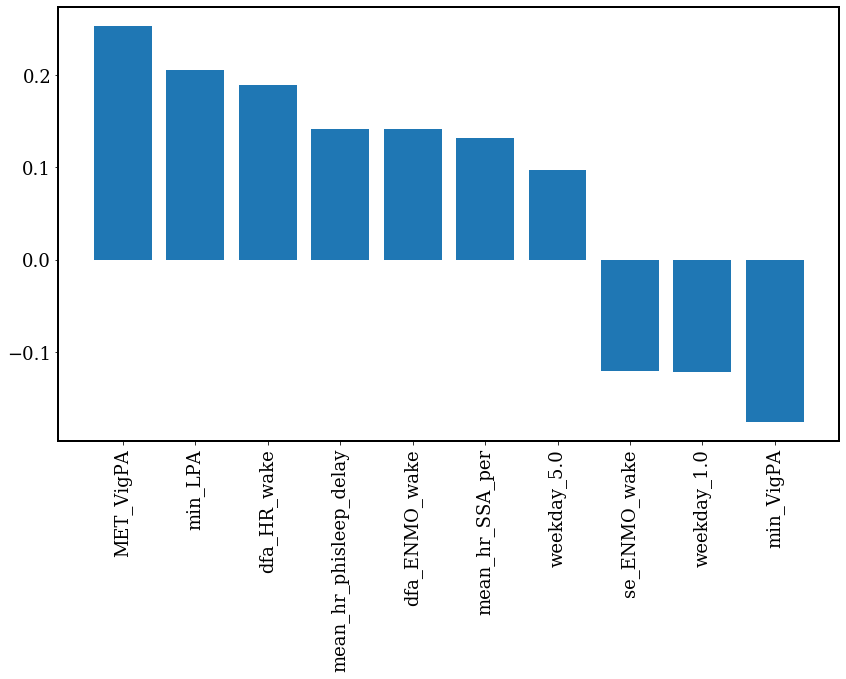

                                 OLS Regression Results                                
Dep. Variable:                    TST   R-squared (uncentered):                   0.722
Model:                            OLS   Adj. R-squared (uncentered):             -0.671
Method:                 Least Squares   F-statistic:                             0.5183
Date:                Thu, 25 Jun 2020   Prob (F-statistic):                       0.804
Time:                        22:14:00   Log-Likelihood:                         -2.7438
No. Observations:                  12   AIC:                                      25.49
Df Residuals:                       2   BIC:                                      30.34
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [60]:
#Recursive Feature Elimination 1
col1 = 'TST'
X_col1 = d_regsz.drop(sleep_features,axis=1)
y_col1 = d_regsz[col1]

X_train,X_test,y_train,y_test=train_test_split(X_col1,y_col1, test_size=0.2, random_state=123)

rfe1 = RFE(estimator=LinearRegression(), n_features_to_select=10, verbose=0)
model_rfe_1 = rfe1.fit(X_train, y_train)

print(X_train.columns[rfe1.support_])
print(dict(zip(X_train.columns, rfe1.ranking_)))
print(rfe1.estimator_.coef_)
print('train_score:',rfe1.score(X_train,y_train))
print('test_score:',rfe1.score(X_test,y_test))

# negate the coeff. to sort them in descending order
selected = pd.DataFrame(zip(X_train.columns[rfe1.support_], rfe1.estimator_.coef_))
print(selected)
sorting = selected.sort_values(1,ascending=False)
print(sorting)

plt.bar(sorting[0], sorting[1])
plt.xticks(rotation=90)
plt.show()

mask = X_train.columns[rfe1.support_]
X_col1 = sm.add_constant(X_col1)
model_col1_sm = sm.OLS(y_train, X_train[mask]).fit() ## sm.OLS(output, input)
predictions = model_col1_sm.predict(X_test[mask])

# Print out the statistics
print(model_col1_sm.summary())

Index(['MET_Sed', 'MET_VigPA', 'dfa_HRV_wake', 'ENMO_SSA_per',
       'mean_hr_SSA_per', 'ENMO_phisleep_delay', 'mean_hr_SSA_phi_t',
       'weekday_2.0', 'weekday_4.0', 'weekday_6.0'],
      dtype='object')
{'MET_Sed': 1, 'MET_MVPA': 10, 'MET_VigPA': 1, 'min_MVPA': 6, 'min_LPA': 8, 'w_length': 15, 'dfa_ENMO_wake': 2, 'dfa_HR_wake': 16, 'dfa_HRV_wake': 1, 'se_ENMO_wake': 11, 'se_HR_wake': 4, 'se_HRV_wake': 17, 'ENMO_SSA_per': 1, 'mean_hr_SSA_per': 1, 'ENMO_phisleep_delay': 1, 'mean_hr_phisleep_delay': 12, 'RMR': 20, 'VO2max': 9, 'age': 18, 'BMI': 19, 'SRI': 3, 'ENMO_SSA_phi_t': 5, 'mean_hr_SSA_phi_t': 1, 'weekday_1.0': 7, 'weekday_2.0': 1, 'weekday_3.0': 13, 'weekday_4.0': 1, 'weekday_5.0': 14, 'weekday_6.0': 1}
[-2.92641448e-31  1.54912328e-30 -5.02278274e-31 -1.75736741e-30
  3.88863390e-30  1.87904903e-30  3.38625781e-30  2.94297530e-30
 -4.23749028e-30 -4.48494591e-31]
train_score: 0.0
test_score: 0.0
                     0             1
0              MET_Sed -2.926414e-31
1      

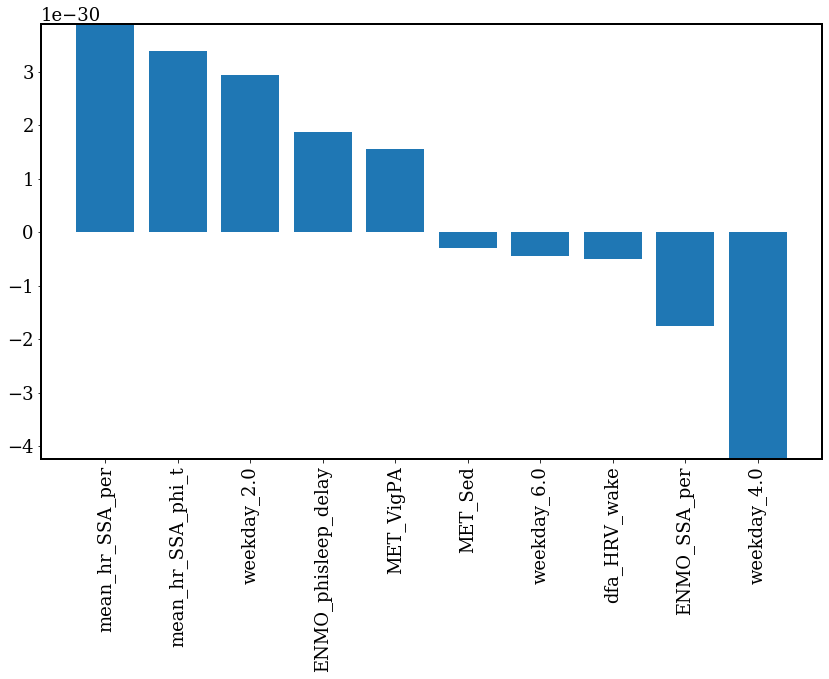

                                 OLS Regression Results                                
Dep. Variable:                   SEff   R-squared (uncentered):                   0.831
Model:                            OLS   Adj. R-squared (uncentered):             -0.012
Method:                 Least Squares   F-statistic:                             0.9856
Date:                Thu, 25 Jun 2020   Prob (F-statistic):                       0.603
Time:                        22:15:40   Log-Likelihood:                          1.9577
No. Observations:                  12   AIC:                                      16.08
Df Residuals:                       2   BIC:                                      20.93
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [63]:
#Recursive Feature Elimination 2
col1 = 'SEff'
X_col1 = d_regsz.drop(sleep_features,axis=1)
y_col1 = d_regsz[col1]

X_train,X_test,y_train,y_test=train_test_split(X_col1,y_col1, test_size=0.2, random_state=111)

rfe2 = RFE(estimator=LinearRegression(), n_features_to_select=10, verbose=0)
model_rfe_2 = rfe2.fit(X_train, y_train)

print(X_train.columns[rfe2.support_])
print(dict(zip(X_train.columns, rfe2.ranking_)))
print(rfe2.estimator_.coef_)
print('train_score:',rfe2.score(X_train,y_train))
print('test_score:',rfe2.score(X_test,y_test))

# negate the coeff. to sort them in descending order
selected2 = pd.DataFrame(zip(X_train.columns[rfe2.support_], rfe2.estimator_.coef_))
print(selected2)
sorting2 = selected2.sort_values(1,ascending=False)
print(sorting2)

plt.bar(sorting2[0], sorting2[1])
plt.xticks(rotation=90)
plt.show()

mask2 = X_train.columns[rfe2.support_]
X_col1 = sm.add_constant(X_col1)
model_col2_sm = sm.OLS(y_train, X_train[mask2]).fit() ## sm.OLS(output, input)
predictions = model_col2_sm.predict(X_test[mask2])

# Print out the statistics
print(model_col2_sm.summary())

Index(['dfa_HRV_wake', 'se_ENMO_wake', 'se_HRV_wake', 'ENMO_SSA_per',
       'mean_hr_SSA_per', 'RMR', 'VO2max', 'age', 'ENMO_SSA_phi_t',
       'weekday_4.0'],
      dtype='object')
{'MET_Sed': 12, 'MET_MVPA': 19, 'MET_VigPA': 14, 'min_MVPA': 11, 'min_VigPA': 10, 'min_LPA': 13, 'w_length': 15, 'dfa_ENMO_wake': 20, 'dfa_HR_wake': 2, 'dfa_HRV_wake': 1, 'se_ENMO_wake': 1, 'se_HR_wake': 18, 'se_HRV_wake': 1, 'ENMO_SSA_per': 1, 'mean_hr_SSA_per': 1, 'ENMO_phisleep_delay': 6, 'mean_hr_phisleep_delay': 4, 'RMR': 1, 'VO2max': 1, 'age': 1, 'BMI': 17, 'ENMO_SSA_phi_t': 1, 'mean_hr_SSA_phi_t': 8, 'weekday_1.0': 16, 'weekday_2.0': 5, 'weekday_3.0': 9, 'weekday_4.0': 1, 'weekday_5.0': 7, 'weekday_6.0': 3}
[-4.95659140e-16 -2.58943984e-16 -1.16267283e-15  4.59282982e-16
  8.84338980e-16 -2.76603876e-01 -8.15042889e-01  4.67123437e-01
  2.98513279e-16  2.13381932e-16]
train_score: 1.0
test_score: 1.0
                 0             1
0     dfa_HRV_wake -4.956591e-16
1     se_ENMO_wake -2.589440e-16
2

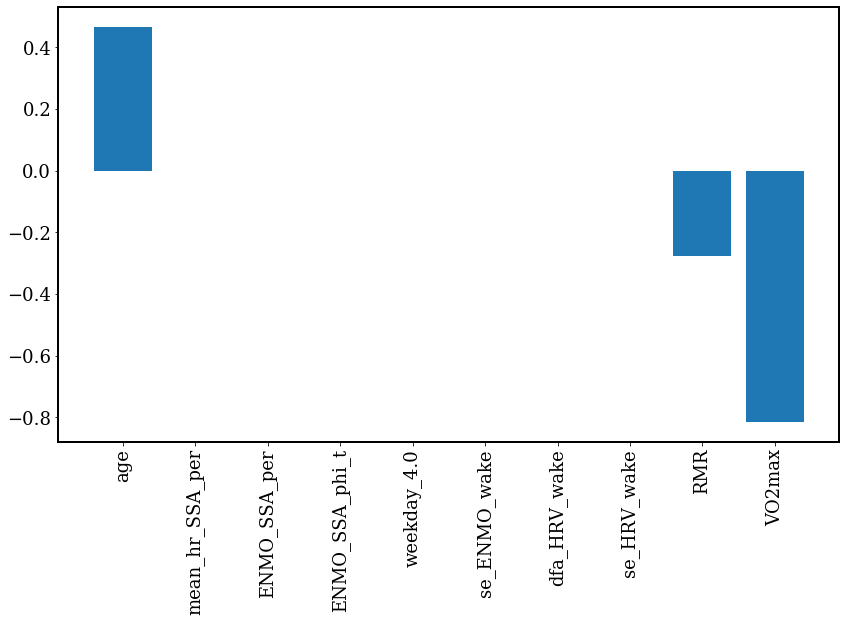

                            OLS Regression Results                            
Dep. Variable:                    SRI   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.147e+29
Date:                Thu, 25 Jun 2020   Prob (F-statistic):           8.72e-30
Time:                        22:18:19   Log-Likelihood:                 391.68
No. Observations:                  12   AIC:                            -763.4
Df Residuals:                       2   BIC:                            -758.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
dfa_HRV_wake     4.441e-16   5.59e-15     

In [65]:
#Recursive Feature Elimination 2
col1 = 'SRI'
X_col1 = d_regsz.drop(sleep_features+['SRI'],axis=1)
y_col1 = d_regsz[col1]

X_train,X_test,y_train,y_test=train_test_split(X_col1,y_col1, test_size=0.2, random_state=111)

rfe3 = RFE(estimator=LinearRegression(), n_features_to_select=10, verbose=0)
model_rfe_3 = rfe3.fit(X_train, y_train)

print(X_train.columns[rfe3.support_])
print(dict(zip(X_train.columns, rfe3.ranking_)))
print(rfe3.estimator_.coef_)
print('train_score:',rfe3.score(X_train,y_train))
print('test_score:',rfe3.score(X_test,y_test))

# negate the coeff. to sort them in descending order
selected3 = pd.DataFrame(zip(X_train.columns[rfe3.support_], rfe3.estimator_.coef_))
print(selected3)
sorting3 = selected3.sort_values(1,ascending=False)
print(sorting3)

plt.bar(sorting3[0], sorting3[1])
plt.xticks(rotation=90)
plt.show()

mask3 = X_train.columns[rfe3.support_]
X_col1 = sm.add_constant(X_col1)
model_col3_sm = sm.OLS(y_train, X_train[mask3]).fit() ## sm.OLS(output, input)
predictions = model_col3_sm.predict(X_test[mask3])

# Print out the statistics
print(model_col3_sm.summary())